In [2]:
import ref_index as RF
from os.path import exists
from numba import jit
import matplotlib.pylab as plt
from scipy.interpolate import UnivariateSpline
from hapi import *
import requests as R
import numpy as np
from scipy.interpolate import CubicSpline, RectBivariateSpline
%matplotlib widget
#


@jit(nopython=True)
def gauss(x, fwhm):
    sigma = fwhm/2./np.sqrt(2*np.log(2.))
    return (np.exp(-(x*x/2/sigma/sigma))/sigma/np.sqrt(2*np.pi))


Kb = 1.380649e-23  # J/K Boltzmans constant
h = 6.626176e-34  # Plancks constant
AMU = 1.6603145e-27
C = 299792458.  # m/s. Speed of light in vacuo


HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [3]:
print("Before, figure default size is: ", plt.rcParams["figure.figsize"])
plt.rcParams["figure.figsize"] = (7, 5)
print("After, figure default size is: ", plt.rcParams["figure.figsize"])


Before, figure default size is:  [6.4, 4.8]
After, figure default size is:  [7.0, 5.0]


In [4]:
db_begin('Abanddata')
if not exists('./Abanddata/oxygen2.header'):

    fetch_by_ids('oxygen', [36], 1/776e-7, 1/749e-7)
c2 = 1.4387770  # CM K


Using Abanddata


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: oxygen
  65536 bytes written to Abanddata/oxygen.data
Header written to Abanddata/oxygen.header
END DOWNLOAD
                     Lines parsed: 199
PROCESSED


In [5]:
url = "http://129.16.35.2:8080/msis/2019-02-02T12:00:00/70/130/150"
#url = "http://83.252.31.240:59059/msis/2019-06-20T12:00:00/80/130/150"
url = "http://129.16.35.2:8080/msis/2019-12-02T12:00:00/0/130/150"

atm = R.get(url).json()
N = np.array(atm['n2'])+np.array(atm['o2'])+np.array(atm['o'])
pres = N*Kb*atm['T']
atm['p'] = pres
z = np.array(atm['z'])
o2 = np.array(atm['o2'])/1e6  # to cm-3
T = atm['T']


In [6]:
select('oxygen', ParameterNames=('nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp'),
       Conditions=('==', 'global_upper_quanta', ('STR', ('       b      0'))),
       DestinationTableName='tmp')
nu, sw, iso, a, elow, gp, gpp = np.array(getColumns(
    'tmp', ['nu', 'sw', 'local_iso_id', 'a', 'elower', 'gp', 'gpp']))

for i in range(a.shape[0]):
    a[i] *= abundance(7, iso[i])
    sw[i] *= abundance(7, iso[i])
eup = elow+nu
1e8/min(nu), 1e8/max(nu), min(nu), max(nu)


(7756.231169079724, 7496.700669612073, 12892.859666, 13339.201391)

/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_img/lib/python3.11/site-packages/ipympl/backend_nbagg.py:336: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  self.figure.savefig(buf, format='png', dpi='figure')
/home/waves/anaconda3/envs/MATS_

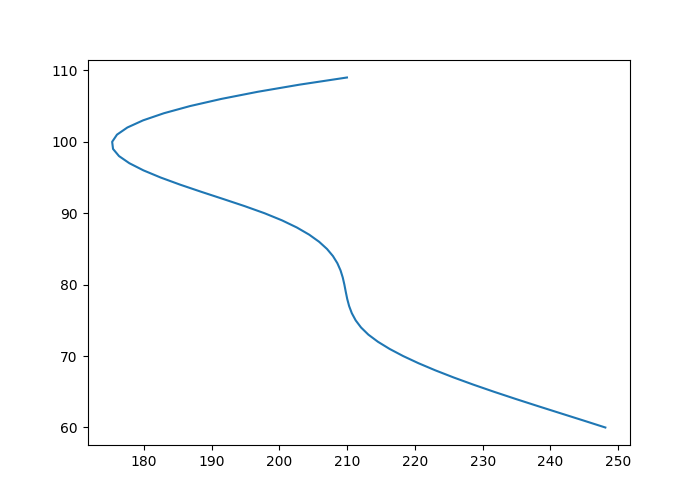

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2.4000000953674316, 'type': 'set_device_pixel_ratio'}


In [7]:
plt.figure()
plt.plot(T[60:110],z[60:110])

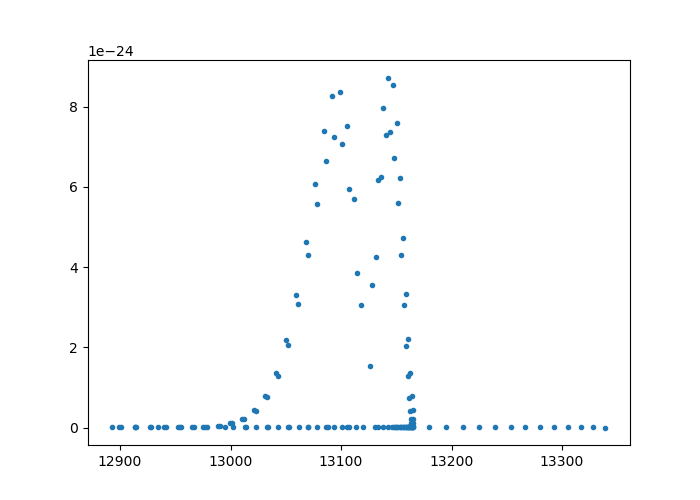

In [57]:
plt.figure()
plt.plot(nu, sw, '.')


In [14]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12950, 13200, 0.002)
grid = np.arange(12800, 13400, 0.002)
sigma = np.zeros([len(z), len(grid)])
emission = np.zeros([len(z), len(grid)])
for layer in range(len(z)):
    print('layer number = {}'.format(layer))
    Sjlayer = sw*298/T[layer]*np.exp(1.439*elow*(T[layer]-298)/298/T[layer])
    intens = gp*a*np.exp(-c2*eup/T[layer])*nu*nu
    intens /= intens.sum()
    DfwhmLayer = Dfwhm*np.sqrt(T[layer]/298.)
    for i in range(len(nu)):
        sigma[layer, :] += (Sjlayer[i]*gauss(grid-nu[i], DfwhmLayer[i]))
        emission[layer, :] += (intens[i]*gauss(grid-nu[i], DfwhmLayer[i]))


layer number = 0
layer number = 1
layer number = 2
layer number = 3
layer number = 4
layer number = 5
layer number = 6
layer number = 7
layer number = 8
layer number = 9
layer number = 10
layer number = 11
layer number = 12
layer number = 13
layer number = 14
layer number = 15
layer number = 16
layer number = 17
layer number = 18
layer number = 19
layer number = 20
layer number = 21
layer number = 22
layer number = 23
layer number = 24
layer number = 25
layer number = 26
layer number = 27
layer number = 28
layer number = 29
layer number = 30
layer number = 31
layer number = 32
layer number = 33
layer number = 34
layer number = 35
layer number = 36
layer number = 37
layer number = 38
layer number = 39
layer number = 40
layer number = 41
layer number = 42
layer number = 43
layer number = 44
layer number = 45
layer number = 46
layer number = 47
layer number = 48
layer number = 49
layer number = 50
layer number = 51
layer number = 52
layer number = 53
layer number = 54
layer number = 55
la

In [15]:
np.save('o2AbandsigmaDec0N0-150', sigma)
np.save('o2AbandemissionDec0N0-150', emission)


In [16]:

sigma = np.load('o2AbandsigmaDec0N0-150.npy')
emission = np.load('o2AbandemissionDec0N0-150.npy')


In [17]:
grid.shape



(300000,)

In [18]:
@jit(nopython=True, cache=True)
def path_z(z_top, z_t, sol_zen, nsteps):
    Re = 6375.  # km
    sol_zen /= 180/np.pi
    B = np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
    S_top = np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

    Ret2 = (Re + z_t)**2
    step = S_top/nsteps
    S_top_half = S_top - step/2
    z_step = [np.sqrt(Ret2 + (S_top_half - i*step)**2 - 2*(Re + z_t) *
                      (S_top_half - i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps)]
    return (z_step, step)


NameError: name 'sigma2' is not defined

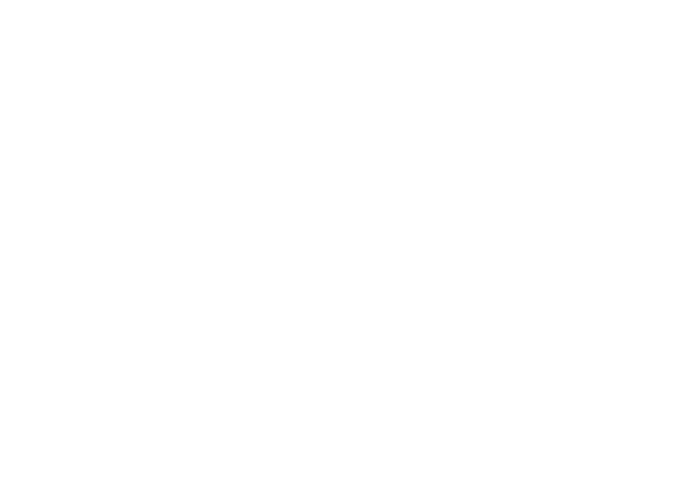

In [19]:
plt.figure()
plt.plot(grid[45500:46500],sigma[50, 45500:46500].T,grid[45500:46500],sigma2[50, 45500:46500].T)
#plt.plot(grid,sigma[50,:])

In [20]:
deltaz = np.diff(z).mean()
for i in range(emission.shape[0]):
    emission[i, :] /= emission[i, :].sum()
emissum = emission[-1, :].sum()
print(emissum)
no_steps = 100
tanheights = np.arange(30, 120, 5)
taus = np.zeros((sigma.shape[1], 2*no_steps-1, len(tanheights)))
i = 0
path_steps = []
factor = []

for tanz in tanheights:
    z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
    path_steps.append(path_step)
    z_paths.extend(z_paths[-2::-1])
    zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
    # emissum = emission[zi, :].sum()/no_steps/2
    tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, np.log(o2))))
           ).cumsum(axis=1)*path_step * 1e5
    taus[:, :, i] = tau
    factor.append(((np.exp(-taus[:, :, i])*emission[zi, :].T)).sum(0)/emissum)
    i += 1


0.9999999999999999


In [21]:
testtest=(filters@(np.exp(-taus[:, :, i])*emission[zi, :].T))/emissum

NameError: name 'filters' is not defined

In [22]:
ls

AWSexampelBilder.py
Abandabscorr.ipynb
Abanddata/
Checkgeoid.ipynb
Doppler.ipynb
Ephemexperimets.ipynb
F-N-UV1_transmission_air_6degr.dat
F-N-UV2_transmission_air_6degr.dat
Figure 1.png
Figure 126.png
Figure 127.png
Figure 15.png
Figure 2.png
Figure 4.png
Figure 48.png
Figure 49.png
Figure 5.png
Figure 52.png
Figure 6.png
Figure 62.png
Figure 63.png
Figure 71.png
Figure 72.png
FitTle.ipynb
FitTletesting.ipynb
Forcemodel.ipynb
ForcemodelTesting.ipynb
GetMATStle.ipynb
IR1Decvertest.nc
IR1Feb11vertest.nc
IR1Mar29vertest.nc
IR1mars31vertest.nc
IR2Decvertest.nc
IR2Feb11vertest.nc
IR2Mar29vertest.nc
IR2mars31vertest.nc
IR3Decvertest.nc
IR3Feb11vertest.nc
IR3Mar29vertest.nc
IR3mars31vertest.nc
IR4Decvertest.nc
IR4Feb11vertest.nc
IR4Mar29vertest.nc
IR4mars31vertest.nc
IRAabscorr.ipynb
IRAband.ipynb
Leap_Second.dat
Leap_Second.old1.dat
MATS-L1-processing/
MATS-analysis/
MATS-analysis_save/
MATS-planningtool/
MATS-utility-functions/
MATS_FOVandSkyMap.ipynb
MATS_Platform_TEST_LEVEL1A_20221019-131

NameError: name 'testtest' is not defined

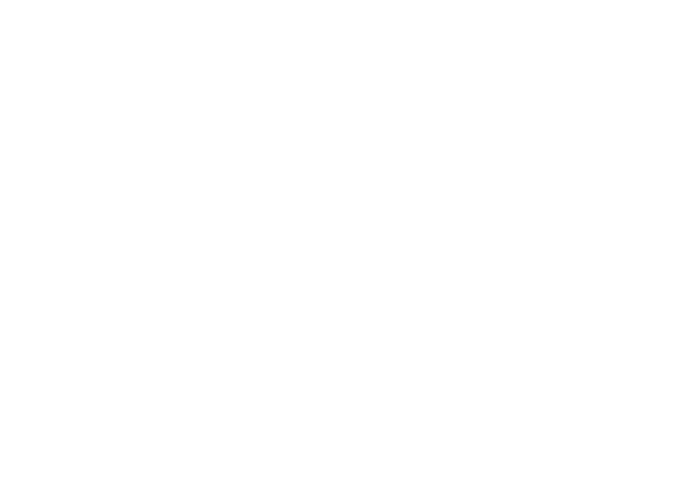

In [23]:
plt.figure()
plt.plot(testtest.T)

In [25]:
IR1=np.loadtxt('/Users/donal/projekt/SIW/MATS-analysis/Donal/retrievals/Datafiles/F-N-IR1-ABandCenter_transmission_air_6degr.dat',skiprows=1,unpack=True)
IR2=np.loadtxt('MATS-analysis/Donal/retrievals/Datafiles/F-N-IR2-ABandTotal_air_6degr.dat',skiprows=1,unpack=True)
IR3=np.loadtxt('MATS-analysis/Donal/retrievals/Datafiles/F-N-IR3-BgShort_transmission_air_6degr.dat',skiprows=1,unpack=True)
IR4=np.loadtxt('MATS-analysis/Donal/retrievals/Datafiles/F-N-IR4-BgLong_transmission_air_6degr.dat',skiprows=1,unpack=True)
#convert from wavelength in air to wavelength in vacupe

IR1[0,:]=RF.air2vac(IR1[0,:])
IR2[0,:]=RF.air2vac(IR2[0,:])
IR1[1,:]/=100
IR2[1,:]/=100
IR3[1,:]/=100
IR4[1,:]/=100
filter1=np.interp(grid, 1e7/IR1[0,-1::-1],IR1[1,-1::-1],left=0,right=0)
filter2=np.interp(grid, 1e7/IR2[0,-1::-1],IR2[1,-1::-1],left=0,right=0)
filters=np.vstack([filter1,filter2])

In [26]:
deltaz = np.diff(z).mean()
for i in range(emission.shape[0]):
    emission[i, :] /= emission[i, :].sum()
emissum = emission[-1, :].sum()
print(emissum)
no_steps = 100
tanheights = np.arange(30, 120, 5)
taus = np.zeros((sigma.shape[1], 2*no_steps-1, len(tanheights)))
i = 0
path_steps = []
factor = []
logo2=np.log(o2)
for tanz in tanheights:
    z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
    path_steps.append(path_step)
    z_paths.extend(z_paths[-2::-1])
    zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
    emissum = filters @ emission[zi, :].T
    tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, logo2)))
           ).cumsum(axis=1)*path_step * 1e5
    taus[:, :, i] = tau
    emissions=np.array([emission[zi,:].T/emissum[0,:],emission[zi,:].T/emissum[1,:]])
    #factor.append((filters@(np.exp(-taus[:, :, i])*emission[zi, :].T))/emissum)
    factor.append((filters@(np.exp(-taus[:, :, i])*emissions)))
    i += 1


1.0000000000000002


In [21]:

emission[zi, :].T.shape

(90000, 199)

Text(0.5, 1.0, 'Absorption and IR1/IR2')

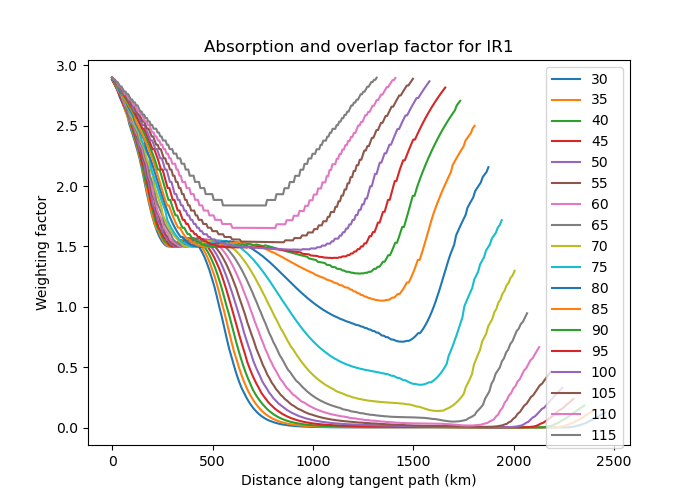

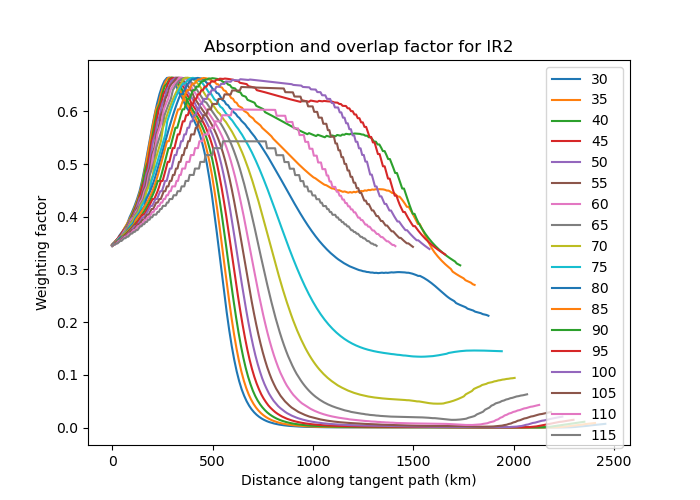

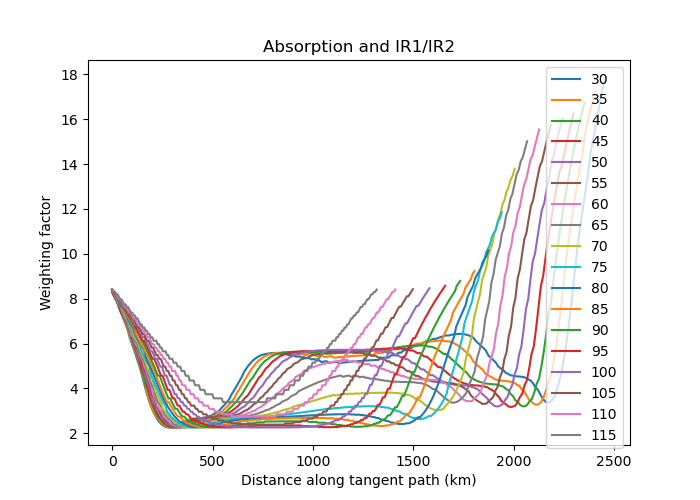

In [27]:
factors= np.array(factor)
plt.figure(figsize=(7, 5))
plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T, np.array(factors[:,0,1,:]).T)
plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and overlap factor for IR1')
plt.figure(figsize=(7, 5))
plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T, np.array(factors[:,1,0,:]).T)
plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and overlap factor for IR2')

plt.figure(figsize=(7, 5))
plt.plot(np.array([np.arange(2*no_steps-1) *
         p for p in path_steps]).T,
         (np.array(factors[:,0,1,:]).T)/(np.array(factors[:,1,0,:]).T))
plt.legend(tanheights)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.title('Absorption and IR1/IR2')




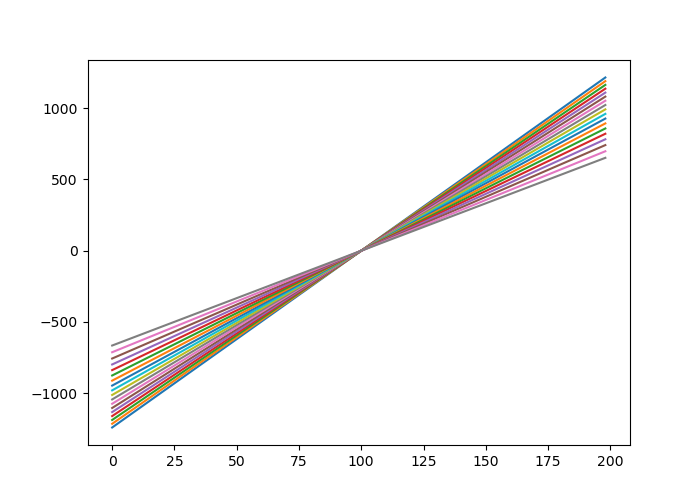

In [82]:
distances = np.array([np.arange(2*no_steps-1) *
                      p for p in path_steps]).T
distances -= distances[100, :]
plt.figure()
plt.plot(distances-distances[100, :])
splinedcorr = []
for i in range(len(tanheights)):
    #splinedcorr.append(CubicSpline(distances[:, i], np.log(factors[i,1,1,:])))
    splinedcorr.append(CubicSpline(distances[:, i], np.log(factors[i,0,0,:]/factors[i,1,1,:])))

(0.0, 1.0)

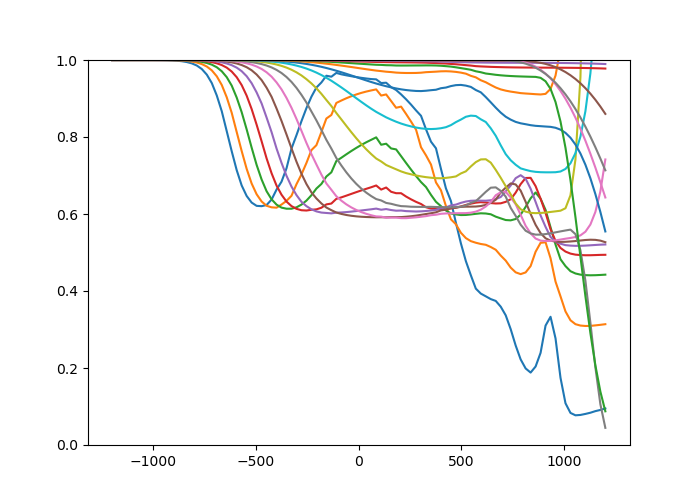

In [83]:
testdist = np.linspace(-1200, 1200, 100)
plt.figure()
corrfactor = np.zeros([len(testdist), len(tanheights)])
for i in range(len(tanheights)):
    corrfactor[:, i] = (splinedcorr[i](testdist))
plt.plot(testdist, np.exp(corrfactor))
plt.ylim([0, 1])


(0.0, 1.0)

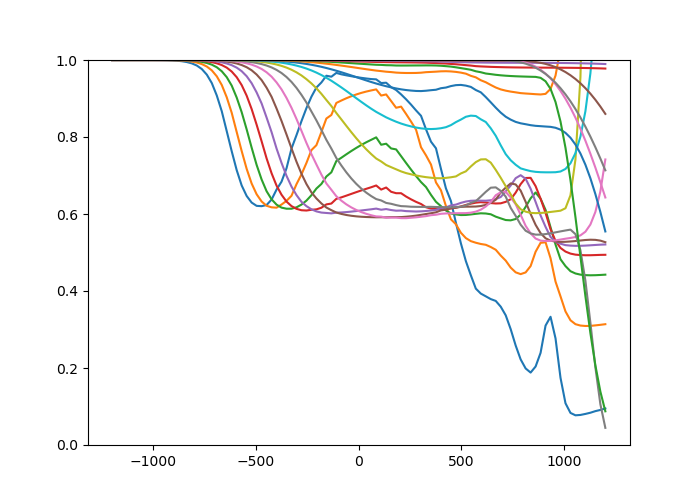

In [84]:
spline2dlogfactor = RectBivariateSpline(tanheights, testdist, corrfactor.T)
plt.figure()
plt.plot(testdist, np.exp(spline2dlogfactor(tanheights, testdist)).T)
plt.ylim([0, 1])


In [85]:
np.save('splinedlogfactorsIR1IR2.npy', [tanheights, splinedcorr])
np.save('splined2dlogfactorsIR1IR2.npy', spline2dlogfactor)


In [86]:
tanz = 30
no_steps = 300
z_paths, path_step = path_z(z[-1], tanz, 90.0, no_steps)
print('Path step = ', path_step)
z_paths.extend(z_paths[-2::-1])
zi = np.floor((np.array(z_paths)-z[0])/deltaz).astype(int)
tau = (sigma[zi, :].T*(np.exp(np.interp(z_paths, z, np.log(o2))))
       ).cumsum(axis=1)*path_step * 1e5


Path step =  4.134611361556378


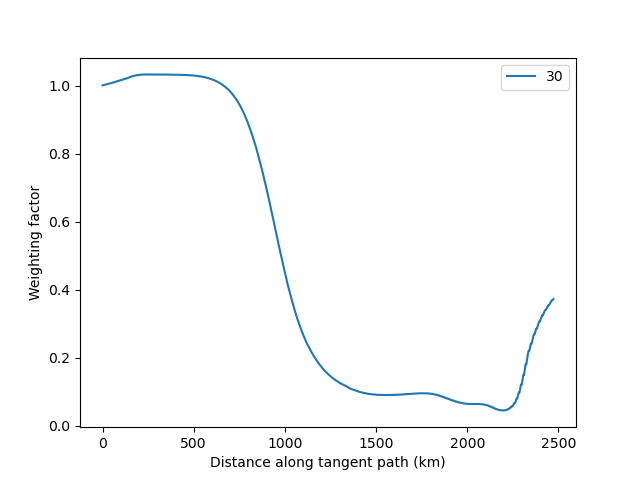

In [15]:
plt.figure()
plt.plot(path_step*np.arange(2*no_steps-1),
         (np.exp(-tau)*emission[zi, :].T).sum(0)/emissum)
plt.xlabel('Distance along tangent path (km)')
plt.ylabel('Weighting factor')
plt.legend(tanheights)


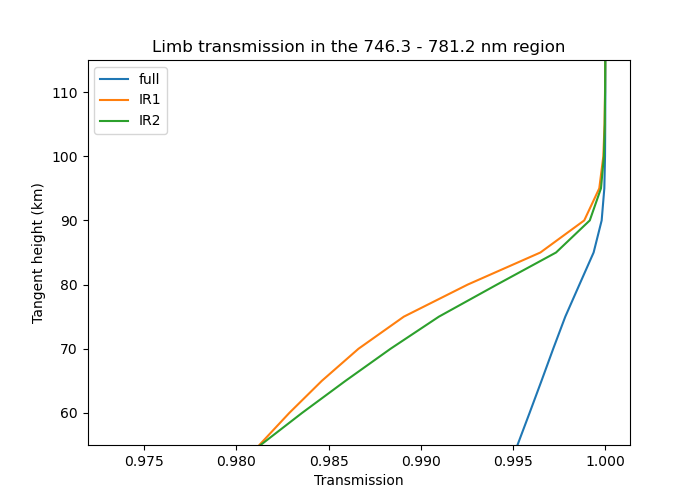

In [183]:
onefilter=np.ones([filters.shape[1]])
plt.figure()
#plt.plot(np.exp(-taus[:, -1, :]).mean(axis=0), tanheights)
plt.plot((onefilter @ np.exp(-taus[:, -1, :])).T/onefilter.sum(), tanheights)
plt.plot(((filters @ np.exp(-taus[:, -1, :])).T/filters.sum(axis=1)), tanheights)
plt.xlabel('Transmission')
plt.ylabel('Tangent height (km)')
plt.title(
    'Limb transmission in the {:.1f} - {:.1f} nm region'.format(1e7/grid[-1], 1e7/grid[0]))
plt.ylim([55, 115])
plt.legend(['full','IR1','IR2'])
#plt.xlim([0.85, 1])


In [175]:
onefilter

array([1., 1., 1., ..., 1., 1., 1.])

0.0

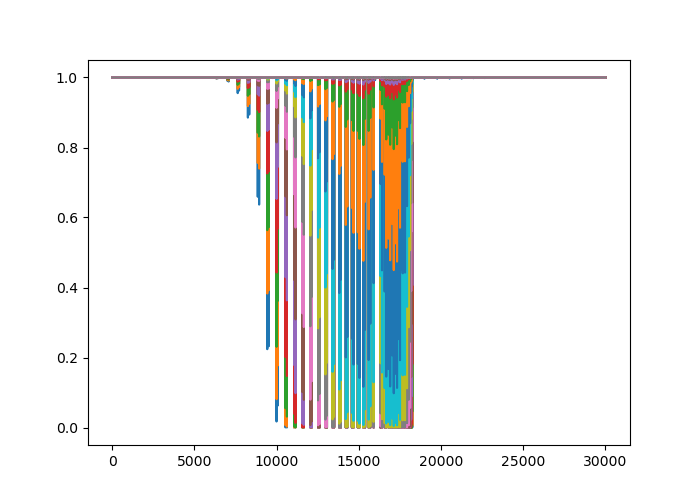

In [160]:
plt.figure()
plt.plot(np.exp(-taus[::10,-1,:]))
#np.exp(-taus[::10,-1,:])
#np.min(taus[:,-1,:])

In [162]:
filters.shape

(2, 300000)

In [134]:
taus.shape


(300000, 199, 18)

In [37]:
1/0.005


200.0

In [38]:
taus = []


In [39]:
np.array(factor).shape


(18, 199)

In [40]:
np.array([np.arange(2*no_steps-1)*p for p in path_steps]).shape


(18, 599)

In [97]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12800, 13400, 0.002)
sigma = np.zeros([len(z), len(grid)])
for i in range(z.shape[0]):
    htabs = absorptionCoefficient_Voigt(SourceTables='tmp', Environment={
                                        "p": pres[i]/101300, "T": T[i]}, OmegaGrid=grid)
    sigma[i, :] = htabs[1]


{'air': 1.0}
0.198130 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.110180 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.098889 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.090468 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.093230 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.096135 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.084256 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.094639 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.090547 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.087837 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.078656 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.093245 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.075055 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.077666 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.088714 seconds elapsed for abscoef; nlines = 148
{'air': 1.0}
0.097216 seconds elapsed fo

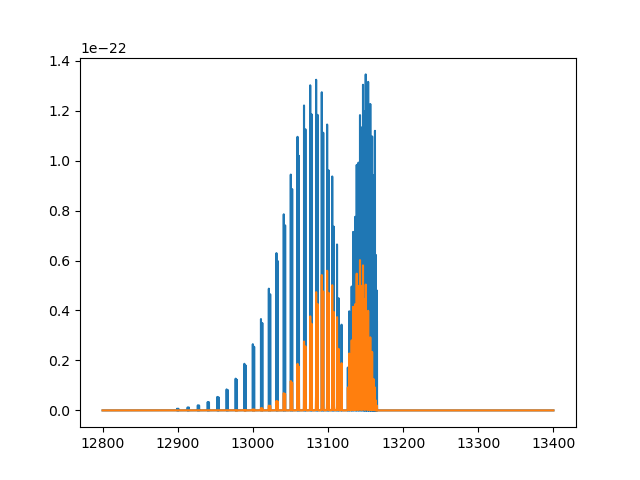

In [100]:
plt.figure()
plt.plot(grid, htabs[1], grid, sigma[1])


In [60]:
select('oxygen',
       Conditions=('==', 'global_upper_quanta', ('STR', ('       b      0'))),
       DestinationTableName='tmp')
nu, sw, gamma, nair, iso, a, elow, gp, gpp = np.array(getColumns(
    'tmp', ['nu', 'sw', 'gamma_air', 'n_air', 'local_iso_id', 'a', 'elower', 'gp', 'gpp']))

for i in range(a.shape[0]):
    a[i] *= abundance(7, iso[i])
    sw[i] *= abundance(7, iso[i])
eup = elow+nu
1e7/min(nu), 1e7/max(nu), min(nu), max(nu)


(775.6231169079724, 749.6700669612073, 12892.859666, 13339.201391)

In [61]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12950, 13200, 0.002)
grid = np.arange(12800, 13400, 0.002)
sigma2 = np.zeros([len(z), len(grid)])
emission2 = np.zeros([len(z), len(grid)])
for layer in range(len(z)):
    print('layer number = {}'.format(layer))
    Sjlayer = sw*298/T[layer]*np.exp(1.439*elow*(T[layer]-298)/298/T[layer])
    intens = gp*a*np.exp(-c2*eup/T[layer])*nu*nu
    intens /= intens.sum()
    DfwhmLayer = Dfwhm*np.sqrt(T[layer]/298.)
    gammaLayer = gamma*pres[layer]/101300*(298/T[layer])**nair
    print('doppler {} Pressure {}'.format(DfwhmLayer[10]/2, gammaLayer[10]))
    winglimit = 1000
    for i in range(len(nu)):
        wing = np.max((winglimit*gammaLayer[i], winglimit*DfwhmLayer[i]/2))
        bl = bisect(grid, nu[i]-wing)
        bu = bisect(grid, nu[i]+wing)
        sigma2[layer, bl:bu] += (Sjlayer[i]*PROFILE_VOIGT(nu[i],
                                 DfwhmLayer[i]/2, gammaLayer[i], 0, grid[bl:bu]))
        emission2[layer, bl:bu] += (intens[i]*PROFILE_VOIGT(nu[i],
                                    DfwhmLayer[i]/2, gammaLayer[i], 0, grid[bl:bu]))


layer number = 0
doppler 0.01420139281070109 Pressure 0.02378656342226615
layer number = 1
doppler 0.01403373245536796 Pressure 0.021527683238903906
layer number = 2
doppler 0.013895107920738638 Pressure 0.019387485449341196
layer number = 3
doppler 0.013773534043066167 Pressure 0.017397377674720833
layer number = 4
doppler 0.013658422928233879 Pressure 0.015572354992331443
layer number = 5
doppler 0.013540257629503068 Pressure 0.013915600492504012
layer number = 6
doppler 0.01341051040169979 Pressure 0.012422101067263705
layer number = 7
doppler 0.013261723226253175 Pressure 0.011081556104693462
layer number = 8
doppler 0.013087720052946918 Pressure 0.00988045445948206
layer number = 9
doppler 0.012883849342768032 Pressure 0.008803706093437546
layer number = 10
doppler 0.012647220881312819 Pressure 0.007835793369671036
layer number = 11
doppler 0.012382820144019337 Pressure 0.006957709615381403
layer number = 12
doppler 0.01211819032406629 Pressure 0.00614250432452046
layer number = 1

In [62]:
nu[0], nu[-1]


(12892.859666, 13339.201391)

In [62]:
np.save('o2A-bandVoightsigmaDec0N0-150', sigma2)
np.save('o2A-bandVoightemissionDec0N0-150', emission2)

In [48]:
layer = 1
pres[layer]


86598.37284254663

#### 

###### 

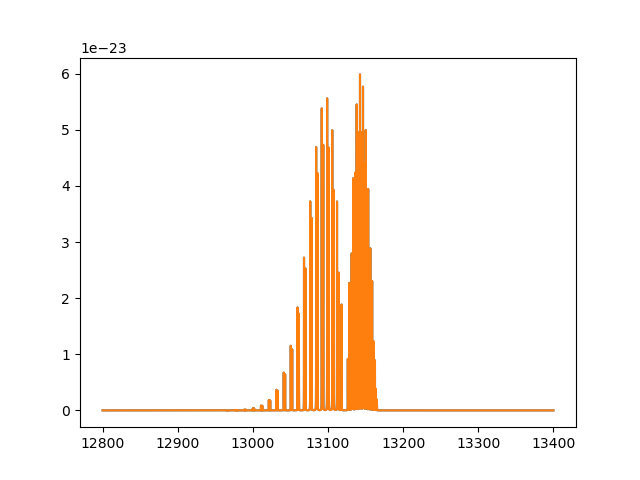

In [93]:

plt.figure()
# plt.plot(grid2,emission2[140],'.',grid1,emission[140])
plt.plot(grid, sigma2[1], grid, sigma2[1])


In [94]:
np.save('o2A-bandVoightsigma0-150', sigma2)
np.save('o2A-bandVoightemission0-150', emission2)


In [87]:
Dfwhm = nu*2/C * np.sqrt(2*Kb*298.*np.log(2)/32/AMU)
grid = np.arange(12800, 13400, 0.002)
t1 = PROFILE_VOIGT(nu[0], Dfwhm[0]/2, gamma[0], 0, grid)
t2 = gauss(grid-nu[0], Dfwhm[100])


(12892.650000018875, 12893.060000018959)

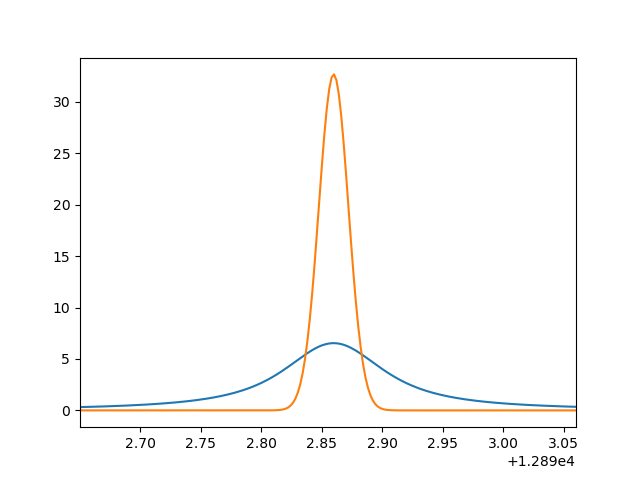

In [88]:
plt.figure()
plt.plot(grid, t1, grid, t2)
bl = bisect(grid, nu[0]-0.21)
bu = bisect(grid, nu[0]+0.2)
plt.xlim([grid[bl], grid[bu]])


AttributeError: 'tuple' object has no attribute 'shape'

In [21]:
url = "http://83.252.31.240:59059/msis/2019-02-02T12:00:00/55/130/150"
a = R.get(url).json()
N = np.array(a['n2'])+np.array(a['o2'])+np.array(a['o'])
pres = N*Kb*a['T']
a['p'] = pres
z = np.array(a['z'])
o2 = np.array(a['o2'])/1e6  # to cm-3
T = np.array(a['T'])


In [22]:
a['T'].shape


AttributeError: 'list' object has no attribute 'shape'

<IPython.core.display.Javascript object>


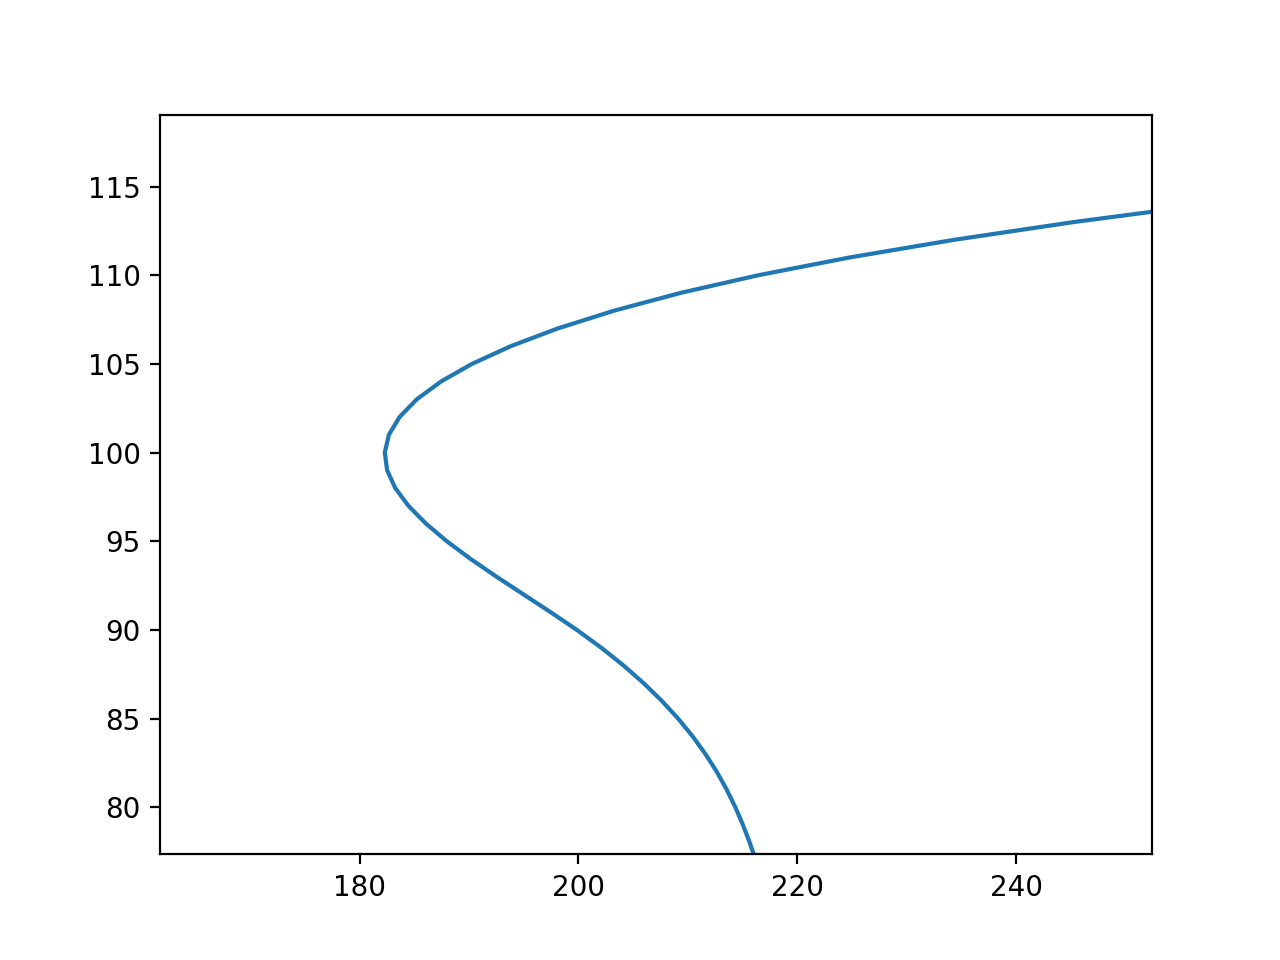

In [23]:
plt.figure()
plt.plot(T, z)
plt.show()
